# Predicting Daily Market Movements with QDA
This experiment uses Quadratic Discriminant Analysis (QDA) to predict daily returns. The experiment starts by analyzing predictors and their relations with daily market movements. Data is then extracted and cleaned and the predictors are extracted from the data. Metrics are computed to determine the viability of the model, providing insghts into the model's fitting and performance. The model is then tested on in-sample and out-of-sample to determine the model's performance. To conclude the experiment, the strategy is simulated to see how the model would have performed historically.

In [115]:
# File imports
import numpy as np
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.multivariate import test_cov_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.stats import normaltest

# Import ISLP-Specific Functions/Classes
from ISLP import confusion_table
from ISLP.models import(
    ModelSpec as MS,
    summarize
)

# Import settings
plt.style.use('ggplot')

### 1. Assessing Predictors and Responses
The predictors used for the QDA model are specified below.

In [116]:
t_data = yf.download('SPY', start='1980-01-01', interval='1d', auto_adjust=True)

# Re-format the yahoo finance data
data = pd.DataFrame()
data['Close'] = t_data['Close']
data['Volume'] = t_data['Volume']

# Calculate the daily returns
data['Returns'] = data['Close'].pct_change()

# Daily return lags
data['Ret_Lag1'] = data['Returns'].shift(1)
data['Ret_Lag2'] = data['Returns'].shift(2)
data['Ret_Lag3'] = data['Returns'].shift(3)
data['Ret_Lag4'] = data['Returns'].shift(4)
data['Ret_Lag5'] = data['Returns'].shift(5)

# Daily volume lags
data['Vol_Lag1'] = data['Volume'].shift(1)
data['Vol_Lag2'] = data['Volume'].shift(2)
data['Vol_Lag3'] = data['Volume'].shift(3)
data['Vol_Lag4'] = data['Volume'].shift(4)
data['Vol_Lag5'] = data['Volume'].shift(5)

# Calculate the rolling volatility
data['volatility_1'] = data['Returns'].rolling(window=2).std()
data['volatility_2'] = data['Returns'].rolling(window=3).std()
data['volatility_3'] = data['Returns'].rolling(window=4).std()
data['volatility_4'] = data['Returns'].rolling(window=5).std()
data['volatility_5'] = data['Returns'].rolling(window=6).std()


# Clean the data
data.dropna(axis=0, inplace=True)
del data['Close']

# Label the return data to their respective classes (K=2)
data['Direction'] = np.where(data['Returns'] > 0, 'Up', 'Down')

# Data to use for fitting additional QDA models
test_data = data.copy()

[*********************100%***********************]  1 of 1 completed


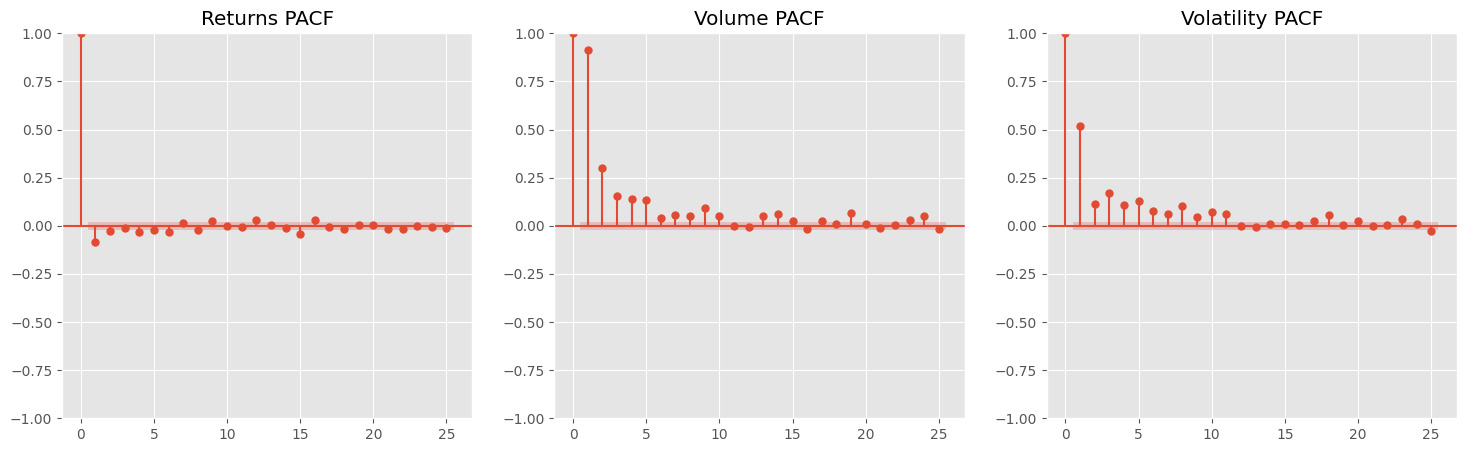

In [117]:
# Plot the partial autocorrelation of the lagged returns, lagged volume, and rolling volatility
N_LAGS = 25

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

plot_pacf(data['Returns'], ax=axes[0], title='Returns PACF', lags=N_LAGS)
plot_pacf(data['Volume'], ax=axes[1],  title='Volume PACF', lags=N_LAGS)
plot_pacf(data['volatility_1'], ax=axes[2],  title='Volatility PACF', lags=N_LAGS)
plt.show()

In [118]:
# Calculate the correlations between the predictors and the daily returns
for col in data.columns:
    if col not in ['Returns', 'Close', 'Volume', 'Direction']:
        correlation = np.corrcoef(data['Returns'], data[col])[0][1]

        print(f'Correlation (Returns, {col}) = {correlation}')

Correlation (Returns, Ret_Lag1) = -0.08287064300367444
Correlation (Returns, Ret_Lag2) = -0.01927793753695915
Correlation (Returns, Ret_Lag3) = -0.00867585820149196
Correlation (Returns, Ret_Lag4) = -0.02785700098559653
Correlation (Returns, Ret_Lag5) = -0.01847788994299686
Correlation (Returns, Vol_Lag1) = 0.003711976196291437
Correlation (Returns, Vol_Lag2) = 0.003933535851920733
Correlation (Returns, Vol_Lag3) = -0.0017386823872465253
Correlation (Returns, Vol_Lag4) = 0.0017601800331654865
Correlation (Returns, Vol_Lag5) = -0.0013111176729744605
Correlation (Returns, volatility_1) = 0.048282031049032365
Correlation (Returns, volatility_2) = 0.02955016693278482
Correlation (Returns, volatility_3) = 0.02905216843891525
Correlation (Returns, volatility_4) = 0.022468072297224213
Correlation (Returns, volatility_5) = 0.018668592213958366


The PACF plots for the three general versions of the predictors suggest that there is autocorrelation in the predictors (particularly strong autocorrelation in Volume and Volatility). Futhermore, the correlations between the identified predictors and the daily returns are weak, suggesting there is an insignificant linear relationship between the response and the predictor, justifying the use of the QDA model rather than a linear classifier.

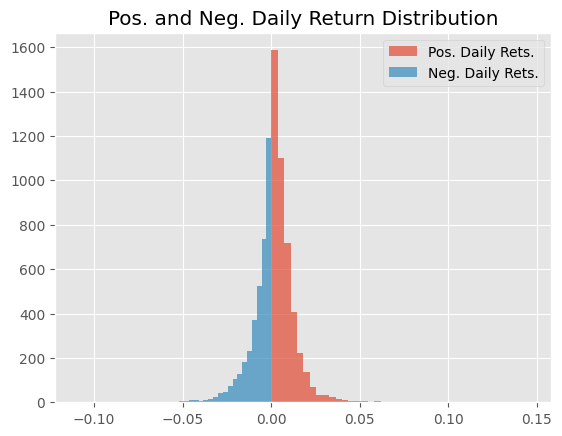

Number of Positive Daily Returns: 4380 | 53.99408284023669%
Number of Negative Daily Returns: 3732 | 46.005917159763314%


In [119]:
# Extract the positive and negative daily returns
positive_rets = data['Returns'][data['Returns'] > 0]
negative_rets = data['Returns'][data['Returns'] <= 0]

# Plot the distributions of the positive and negative daily returns
plt.hist(positive_rets, bins=40, alpha=0.7, label='Pos. Daily Rets.')
plt.hist(negative_rets, bins=40, alpha=0.7, label='Neg. Daily Rets.')
plt.title('Pos. and Neg. Daily Return Distribution')
plt.legend()
plt.show()

print(f'Number of Positive Daily Returns: {len(positive_rets)} | {(len(positive_rets) / len(data)) * 100}%')
print(f'Number of Negative Daily Returns: {len(negative_rets)} | {(len(negative_rets) / len(data)) * 100}%')

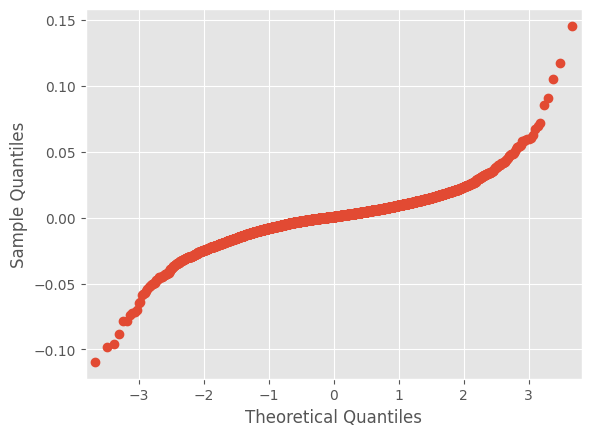

In [120]:
# Q-Q Plot of daily returns
sm.qqplot(data['Returns'])
plt.show()

#### Discussion and Findings
Observing the Q-Q Plot, the pronounced S-curve of the plot indicates that the distribution of daily returns is either skewed or has different tails compared to the normal distribution. As seen in the distribution of daily returns, the distribution is left-skewed, with more positive daily returns. Rougly 54% of the daily returns are positive and 46% of the daily returns are negative. By inspection, the daily return distribution appears to have fat tails with some daily returns around +/-5%. Because QDA assumes predictors are drawn from a normal distribution, the code below tests the predictors for normality.<br>
Null Hypothesis: Data is a normal distribution<br>
Alternative Hypothesis: Data is not a normal distribution

In [121]:
# Test the predictors for normality
alpha = 0.05

# Seperate the predictor columns
predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

for predictor in predictor_columns:
    stat, pvalue = normaltest(data[predictor])

    if pvalue <= alpha:
        print(f'95% confident that: {predictor} is normally distributed.')
    else:
        print(f'95% confident that: {predictor} is not normally distributed.')

95% confident that: Ret_Lag1 is normally distributed.
95% confident that: Ret_Lag2 is normally distributed.
95% confident that: Ret_Lag3 is normally distributed.
95% confident that: Ret_Lag4 is normally distributed.
95% confident that: Ret_Lag5 is normally distributed.
95% confident that: Vol_Lag1 is normally distributed.
95% confident that: Vol_Lag2 is normally distributed.
95% confident that: Vol_Lag3 is normally distributed.
95% confident that: Vol_Lag4 is normally distributed.
95% confident that: Vol_Lag5 is normally distributed.
95% confident that: volatility_1 is normally distributed.
95% confident that: volatility_2 is normally distributed.
95% confident that: volatility_3 is normally distributed.
95% confident that: volatility_4 is normally distributed.
95% confident that: volatility_5 is normally distributed.


We can see that all of the predictors appear to be a normal distribution at the 95% confidence interval.

In [122]:
# Seperate the predictors and the response
X = MS(predictor_columns).fit_transform(data)
y = data.Direction == 'Up'

In [123]:
# Check collinearity using the variance inflation factor (VIF)
vifs = [VIF(X, i) for i in range(1, X.shape[1])]
vifs = pd.DataFrame({'VIF' : vifs}, index=X.columns[1:])

print(vifs)

                    VIF
Ret_Lag1       1.081826
Ret_Lag2       1.146635
Ret_Lag3       1.149700
Ret_Lag4       1.134637
Ret_Lag5       1.049548
Vol_Lag1       7.847345
Vol_Lag2       9.802603
Vol_Lag3      10.129396
Vol_Lag4       9.958207
Vol_Lag5       7.962580
volatility_1   3.166346
volatility_2   8.367356
volatility_3  15.964778
volatility_4  25.040621
volatility_5  16.342150


We can see from the VIF values that there are collinear predictors, particularly lagged volume and rolling volatility. To remove the collinearity, each predictor (lagged volume and rolling volatility) will be combined into their own single predictors by taking the mean value of their lagged/rolling period.

In [124]:
# Combine the collinear predictors
data['Lag_Volume'] = data[['Vol_Lag1', 'Vol_Lag2', 'Vol_Lag3', 'Vol_Lag4', 'Vol_Lag5']].mean(axis=1)
data['Lag_Volatility'] = data[['volatility_1', 'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5']].mean(axis=1)

# Remove the lagged columns
data.drop(columns=[
    'Vol_Lag1', 'Vol_Lag2', 'Vol_Lag3', 'Vol_Lag4', 'Vol_Lag5',
    'volatility_1', 'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5'
], inplace=True)

predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

# NOTE: By removing the Lag_Volume and the Lag_Volatility and keeping the one day lagged volume and volatility, the model performs better AND VIF is lower

In [125]:
NON_PREDICTOR_COLS = 2 # Number of non-predictor columns
p = len(data.columns) - NON_PREDICTOR_COLS
n = len(data)

print(f'Ratio of predictors to observations: {p / n}')

# Seperate the predictors and the response
X = MS(predictor_columns).fit_transform(data)
y = data.Direction == 'Up'

# Check collinearity again using the variance inflation factor (VIF)
vifs = [VIF(X, i) for i in range(1, X.shape[1])]
vifs = pd.DataFrame({'VIF' : vifs}, index=X.columns[1:])

print(vifs)

Ratio of predictors to observations: 0.0009861932938856016
                     VIF
Ret_Lag1        1.013000
Ret_Lag2        1.032533
Ret_Lag3        1.041424
Ret_Lag4        1.047044
Ret_Lag5        1.036248
Lag_Volume      1.243660
Lag_Volatility  1.323992


In [126]:
# Display the basic summary of the data
print(f'Predictor Data Set Shape: {X.shape}')
print(f'Class Distribution: \n{pd.Series(y).value_counts()}')

# NOTE: True is "Up" and False is "Down"

Predictor Data Set Shape: (8112, 8)
Class Distribution: 
Direction
True     4380
False    3732
Name: count, dtype: int64


In [127]:
TRAIN = 0.80
train_len = int(len(data) * TRAIN)

X_train, X_test = X[:train_len], X.iloc[-train_len:]
y_train, y_test = y[:train_len], y.iloc[-train_len:]
D = data.Direction
L_train, L_test = D[:train_len], D.iloc[-train_len:]

# Remove the intercept (set my the MS.fit_transform)
X_train = X_train.drop(columns='intercept')
X_test = X_test.drop(columns='intercept')

In [128]:
# Quadratic discriminant analysis (test data)
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

qda_predictions = qda.predict(X_test)

In [129]:
# Performance metrics
confusion_matrix = confusion_table(qda_predictions, L_test)
print(confusion_matrix)

prediction_rate = np.mean(qda_predictions == L_test)
training_error = np.mean(qda_predictions != L_test)

false_positive_rate = confusion_matrix.iloc[1, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])
false_negative_rate = confusion_matrix.iloc[0, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])

sensitivity = confusion_matrix.iloc[1, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])
specificity = confusion_matrix.iloc[0, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])

print('\nQDA: Test Model Performance ==========')
print(f'Prediction Rate:     {prediction_rate:.4f}')
print(f'Training Error:      {training_error:.4f}')
print(f'Model Sensitivity:   {sensitivity:.4f}')
print(f'Model Specificity:   {specificity:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'False Negative Rate: {false_negative_rate:.4f}')

Truth      Down    Up
Predicted            
Down        929   602
Up         2036  2922

QDA: Test Model Performance ==========
Prediction Rate:     0.5935
Training Error:      0.4065
Model Sensitivity:   0.8292
Model Specificity:   0.3133
False Positive Rate: 0.6867
False Negative Rate: 0.1708


From the model's performance metrics, we can see that it correctly predicts the direction of 59.35% daily market moves, on average. The majority of those predictions result from the model's sensitivity, which correctly predicts "Up" almost 83% of the time. The model performs quite poorly when attempting to predict "Down", with corret predictions only 31% of the time.<br><br>
To see if the performance can be enhanced on both "Up" and "Down" predictions, a combination of additional predictors will be used.

---
#### Model 1
This model uses the lagged returns and the first lagged volume.

In [130]:
# Reload the downloaded data
data = test_data.copy()

# Keep only the first lagged volume
data.drop(columns=[
    'Vol_Lag2', 'Vol_Lag3', 'Vol_Lag4', 'Vol_Lag5',
    'volatility_1', 'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5'
], inplace=True)
predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

# Seperate predictors and response
X = MS(predictor_columns).fit_transform(data)
y = data.Direction == 'Up'

# Set train and test parameters
TRAIN = 0.80
train_len = int(len(data) * TRAIN)

# Seperate train and test data
X_train, X_test = X[:train_len], X.iloc[-train_len:]
y_train, y_test = y[:train_len], y.iloc[-train_len:]
D = data.Direction
L_train, L_test = D[:train_len], D.iloc[-train_len:]

# Remove the intercept (set my the MS.fit_transform)
X_train = X_train.drop(columns='intercept')
X_test = X_test.drop(columns='intercept')

# Quadratic discriminant analysis (test data)
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

qda_predictions = qda.predict(X_test)

# Performance metrics
confusion_matrix = confusion_table(qda_predictions, L_test)
print(confusion_matrix)

prediction_rate = np.mean(qda_predictions == L_test)
training_error = np.mean(qda_predictions != L_test)

false_positive_rate = confusion_matrix.iloc[1, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])
false_negative_rate = confusion_matrix.iloc[0, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])

sensitivity = confusion_matrix.iloc[1, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])
specificity = confusion_matrix.iloc[0, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])

print('\nQDA: Test Model Performance ==========')
print(f'Prediction Rate:     {prediction_rate:.4f}')
print(f'Training Error:      {training_error:.4f}')
print(f'Model Sensitivity:   {sensitivity:.4f}')
print(f'Model Specificity:   {specificity:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'False Negative Rate: {false_negative_rate:.4f}')

Truth      Down    Up
Predicted            
Down        384   389
Up         2581  3135

QDA: Test Model Performance ==========
Prediction Rate:     0.5423
Training Error:      0.4577
Model Sensitivity:   0.8896
Model Specificity:   0.1295
False Positive Rate: 0.8705
False Negative Rate: 0.1104


#### Model 2
This model uses the lagged returns and the first lagged volatility.

In [131]:
# Reload the downloaded data
data = test_data.copy()

# Keep only the first lagged volume
data.drop(columns=[
    'Vol_Lag1', 'Vol_Lag2', 'Vol_Lag3', 'Vol_Lag4', 'Vol_Lag5',
    'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5'
], inplace=True)
predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

# Seperate predictors and response
X = MS(predictor_columns).fit_transform(data)
y = data.Direction == 'Up'

# Set train and test parameters
TRAIN = 0.80
train_len = int(len(data) * TRAIN)

# Seperate train and test data
X_train, X_test = X[:train_len], X.iloc[-train_len:]
y_train, y_test = y[:train_len], y.iloc[-train_len:]
D = data.Direction
L_train, L_test = D[:train_len], D.iloc[-train_len:]

# Remove the intercept (set my the MS.fit_transform)
X_train = X_train.drop(columns='intercept')
X_test = X_test.drop(columns='intercept')

# Quadratic discriminant analysis (test data)
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

qda_predictions = qda.predict(X_test)

# Performance metrics
confusion_matrix = confusion_table(qda_predictions, L_test)
print(confusion_matrix)

prediction_rate = np.mean(qda_predictions == L_test)
training_error = np.mean(qda_predictions != L_test)

false_positive_rate = confusion_matrix.iloc[1, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])
false_negative_rate = confusion_matrix.iloc[0, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])

sensitivity = confusion_matrix.iloc[1, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])
specificity = confusion_matrix.iloc[0, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])

print('\nQDA: Test Model Performance ==========')
print(f'Prediction Rate:     {prediction_rate:.4f}')
print(f'Training Error:      {training_error:.4f}')
print(f'Model Sensitivity:   {sensitivity:.4f}')
print(f'Model Specificity:   {specificity:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'False Negative Rate: {false_negative_rate:.4f}')

Truth      Down    Up
Predicted            
Down       1595   627
Up         1370  2897

QDA: Test Model Performance ==========
Prediction Rate:     0.6922
Training Error:      0.3078
Model Sensitivity:   0.8221
Model Specificity:   0.5379
False Positive Rate: 0.4621
False Negative Rate: 0.1779


#### Model 3
This model uses the lagged returns, first lagged volume, and first lagged volatility.

In [132]:
# Reload the downloaded data
data = test_data.copy()

# Keep only the first lagged volume
data.drop(columns=[
    'Vol_Lag2', 'Vol_Lag3', 'Vol_Lag4', 'Vol_Lag5',
    'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5'
], inplace=True)
predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

# Seperate predictors and response
X = MS(predictor_columns).fit_transform(data)
y = data.Direction == 'Up'

# Set train and test parameters
TRAIN = 0.80
train_len = int(len(data) * TRAIN)

# Seperate train and test data
X_train, X_test = X[:train_len], X.iloc[-train_len:]
y_train, y_test = y[:train_len], y.iloc[-train_len:]
D = data.Direction
L_train, L_test = D[:train_len], D.iloc[-train_len:]

# Remove the intercept (set my the MS.fit_transform)
X_train = X_train.drop(columns='intercept')
X_test = X_test.drop(columns='intercept')

# Quadratic discriminant analysis (test data)
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

qda_predictions = qda.predict(X_test)

# Performance metrics
confusion_matrix = confusion_table(qda_predictions, L_test)
print(confusion_matrix)

prediction_rate = np.mean(qda_predictions == L_test)
training_error = np.mean(qda_predictions != L_test)

false_positive_rate = confusion_matrix.iloc[1, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])
false_negative_rate = confusion_matrix.iloc[0, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])

sensitivity = confusion_matrix.iloc[1, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])
specificity = confusion_matrix.iloc[0, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])

print('\nQDA: Test Model Performance ==========')
print(f'Prediction Rate:     {prediction_rate:.4f}')
print(f'Training Error:      {training_error:.4f}')
print(f'Model Sensitivity:   {sensitivity:.4f}')
print(f'Model Specificity:   {specificity:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'False Negative Rate: {false_negative_rate:.4f}')

Truth      Down    Up
Predicted            
Down       1594   608
Up         1371  2916

QDA: Test Model Performance ==========
Prediction Rate:     0.6950
Training Error:      0.3050
Model Sensitivity:   0.8275
Model Specificity:   0.5376
False Positive Rate: 0.4624
False Negative Rate: 0.1725


After observing the model's performance, the most promising predictors for the QDA model are the lagged returns and the first lagged volume and first lagged volatility. The prediction rate was over 69% and the false positive rate was reduced to 46.24%. To better assess whether this model has real predictive power in financial markets, further validation needs to be completed using various cross-validation resampling techniques. Additionally, the collinearity and covariances between the predictors needs to be further analyzed to confirm the model is not introducing bias or being overfit to the data. It is also worth investigating whether these predictors are consistent across individual constituents in the market, and across benchmarks indicies.

### 2. Cross-Validation
To better assess the best model's test error rate, LOOCV (leave-one-out cross-validation) will be used. Fitting n-1 QDA models, where n is the number of observations in the data set, we can getter a better estimate of the model's performance compared to the simple validation set approach used above. The model being used is the one that keeps the first lagged volume and first lagged volatility.

In [ ]:
# Leave-One-Out Cross Validation

# Reload the data
data = test_data.copy()

errors = []
n = len(data)

# Seperate the predictors and responses
data.drop(columns=[
    'Vol_Lag2', 'Vol_Lag3', 'Vol_Lag4', 'Vol_Lag5',
    'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5'
], inplace=True)

predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

for i in range(n):
    # Split training and test data
    test_data = data.iloc[[i]]                  # ith row only
    train_data = data.drop(index=data.index[i]) # Removed the ith row

    # Extract direction labels
    y_train = train_data['Direction']
    y_test = test_data['Direction'].values[0]

    # Transform predictors
    X_train = MS(predictor_columns).fit_transform(train_data).drop(columns='intercept')
    X_test = MS(predictor_columns).fit_transform(test_data).drop(columns='intercept')

    # Fit QDA and make prediction
    qda = QDA(store_covariance=True)
    qda.fit(X_train, y_train)

    prediction = qda.predict(X_test)

    # Record error
    errors.append(int(prediction[0] != y_test))

# Compute LOOCV error
estimated_error = np.mean(errors)
print(f'Estimated LOOCV Test Error: {estimated_error:.4f}')

Estimated LOOCV Test Error: 0.3045


In [ ]:
# K-Fold Cross Validation

### 3. Predictor Validation
To see how the predictors in the best QDA model relate to eachother, the code below investigates the distribuions of predictors belonging to each class, collinearity between the predictors, and the covariance matrices of the predictors.

### 4. Historical Backtest Performance

### 5. Application to Additional Constituents

### 6. Additional Predictors